In [23]:
import sys
import os
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn import datasets


from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV


from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
import alibi.explainers as ale
from alibi.explainers import ALE, plot_ale
import lime
import lime.lime_tabular
import shap


import warnings
warnings.filterwarnings('ignore')

#os.getcwd()

In [25]:
# chemin pour le fichier py avec les foncitons
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
# fonctions dans le fichier py 
from utils import display_original_pdp_values, detect_variable_types, winsorize_data


In [11]:
#dossier  path
data_path = Path.cwd().parent / "data"

# récupereation des données 
df = pd.read_csv( data_path / "df_clean.csv")
print(df.shape)

(44552, 24)


In [14]:
types = detect_variable_types(df)

num_cols = types["numerical"]
bool_cols = types["boolean"]
ordinal_col = ['Urine_protein']

num_cols.remove("Urine_protein")
bool_cols.remove("smoking")

columns_to_winsorize = [
    'ALT', 'AST', 'Gtp', 'serum_creatinine',
    'LDL', 'HDL', 'triglyceride', 'Cholesterol',
    'fasting_blood_sugar', 'systolic', 'relaxation', 'hemoglobin'
]


# III. Interprétation globale du meilleur modèle 

On relance le modele que nous avons choisi dans la partie 02_modeles

In [15]:
# Repartir proprement
X = df[num_cols + bool_cols + ordinal_col].copy()
y = df["smoking"].copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Winsorisation
for col in columns_to_winsorize:
    X_train[col], X_test[col] = winsorize_data(X_train, X_test, feature=col)

# Préprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('ord', OrdinalEncoder(), ordinal_col),
    ('bool', 'passthrough', bool_cols)
])


In [16]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ))
])

pipeline.fit(X_resampled, y_resampled)

# 2. Prédictions sur X_test
y_pred = pipeline.predict(X_test)

# 3. Évaluation
print("Résultats Gradient Boosting - Undersampling seul :")
print("Recall     :", recall_score(y_test, y_pred))
print("F1-score   :", f1_score(y_test, y_pred))
print("Accuracy   :", accuracy_score(y_test, y_pred))
print("Precision  :", precision_score(y_test, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))


# Pour l’interprétabilité :  modèle et les données transformées
model = pipeline.named_steps['model']
X_test_prepared = pipeline.named_steps['preprocessing'].transform(X_test)
feature_names = num_cols + ordinal_col + bool_cols

Résultats Gradient Boosting - Undersampling seul :
Recall     : 0.8918836140888208
F1-score   : 0.7201681711388649
Accuracy   : 0.7460442150151498
Precision  : 0.6038987971795935
Matrice de confusion :
 [[3736 1910]
 [ 353 2912]]


On vérifie que le modèle réalise correctement une prédiction pour un individu

In [ ]:
#  ex: 1er individu du test
i = 1
# Donnée prétraitée pour cet individu
X_instance = X_test_prepared[i].reshape(1, -1)  # reshape pour garder le bon format
# Prédiction du modèle (classe prédite)
prediction = model.predict(X_instance)[0]
# Probabilité associée 
proba = model.predict_proba(X_instance)[0, 1]

# Valeur réelle
true_label = y_test.iloc[i]
print(f"Individu {i} - Réel : {true_label} | Prédit : {prediction} | Proba d’être fumeur : {proba:.2f}")


Individu 1 - Réel : True | Prédit : True | Proba d’être fumeur : 0.59


## A. Interprétation globale

### 1) Importance des variables

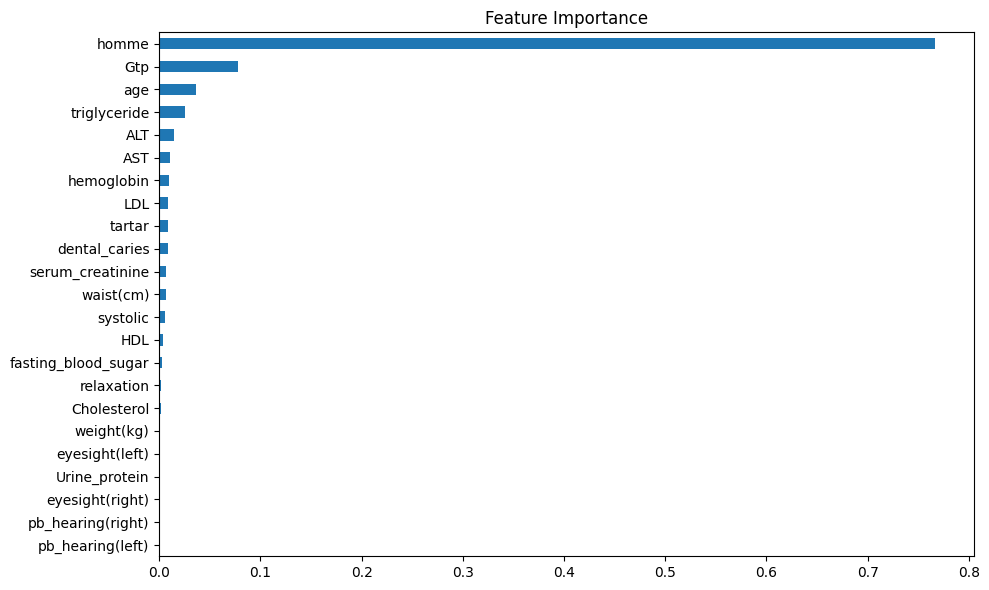

In [ ]:
importances = pd.Series(model.feature_importances_, index=feature_names)
importances.sort_values(ascending=True).plot(kind="barh", figsize=(10, 6), title="Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
importances.sort_values()

pb_hearing(left)       0.000000
pb_hearing(right)      0.000090
eyesight(right)        0.000283
Urine_protein          0.000395
eyesight(left)         0.000817
weight(kg)             0.000984
Cholesterol            0.001793
relaxation             0.002191
fasting_blood_sugar    0.003036
HDL                    0.003628
systolic               0.005623
waist(cm)              0.006834
serum_creatinine       0.006945
dental_caries          0.008365
tartar                 0.008811
LDL                    0.008919
hemoglobin             0.009319
AST                    0.010382
ALT                    0.015086
triglyceride           0.025643
age                    0.036633
Gtp                    0.077739
homme                  0.766484
dtype: float64

### 2) Partial Dependence Plots - PDP
**Variables quantitaves**

Le PDP (Graphique de dépendance partielle) montre comment une variable influence la prédiction en moyenne, en maintenant les autres constantes.

on veut voir comment le modèle généralise sur de nouvelles données, donc on utilisera X_test

Montre l'effet moyen d'une variable sur la prédiction

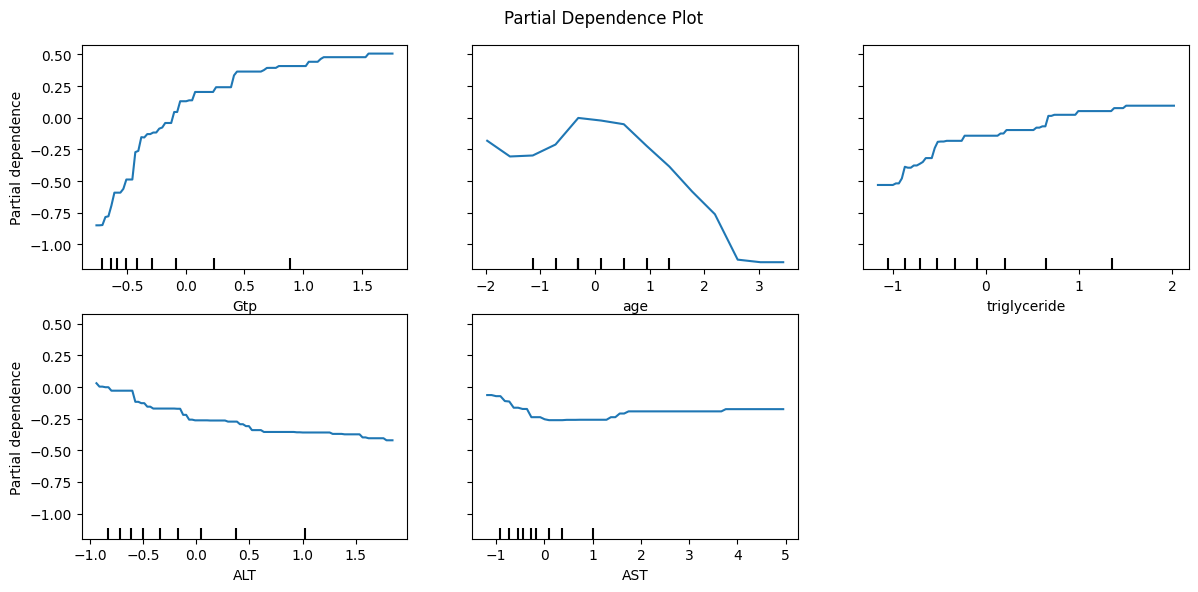

In [24]:
features = ["Gtp", "age" , "triglyceride", "ALT", "AST"] # premiers 5 variables 

_, ax1 = plt.subplots(figsize = (12,6))

PartialDependenceDisplay.from_estimator(
    model,
    X_test_prepared,
    features=features,  
    feature_names=feature_names,
    kind="average",
    grid_resolution=100,
    ax = ax1
)
plt.suptitle("Partial Dependence Plot")
plt.tight_layout()
plt.show()

Nous avons utilisé un pipeline avec standardisation, ce qui a un impact sur l’interprétation directe des Partial Dependence Plots (PDP), car les valeurs des variables sont alors exprimées sur une échelle standardisée (centrée-réduite) comme ci dessus.

Pour une meilleure interprétation, nous allons utiliser  la fonction display_original_pdp_values,  qui permet de retrouver les valeurs originales des variables en inversant la transformation appliquée par le StandardScaler. Cela permet de visualiser les PDP dans les unités réelles (par exemple, années pour l’âge), ce qui facilite l’analyse des effets des variables sur la prédiction

In [11]:
feature_names

['age',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'systolic',
 'relaxation',
 'fasting_blood_sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'serum_creatinine',
 'AST',
 'ALT',
 'Gtp',
 'Urine_protein',
 'dental_caries',
 'tartar',
 'homme',
 'pb_hearing(left)',
 'pb_hearing(right)']

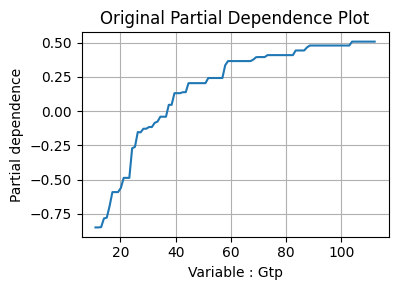

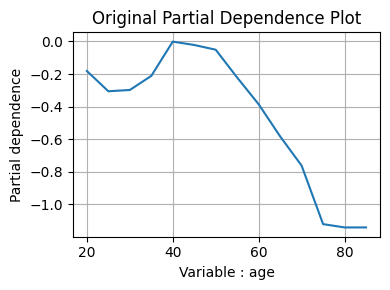

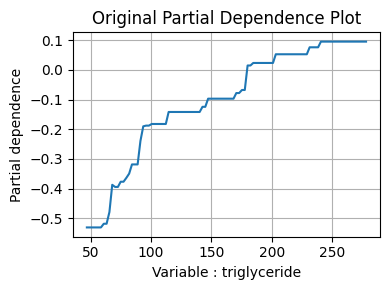

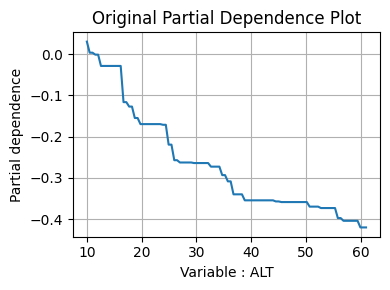

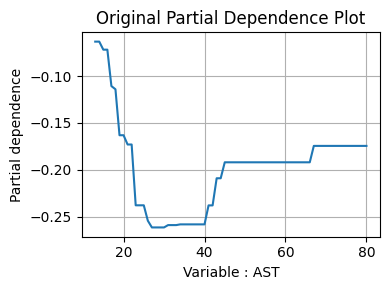

In [12]:
scaler = preprocessor.named_transformers_['num']

# Pour chaque variable, afficher un PDP avec inversion du scaling
for var in features:
    if var in num_cols:  # Vérification que la variable est bien numérique
        index = num_cols.index(var)  # Index dans la partie normalisée
        display_original_pdp_values(
            num_col=index,
            model=model,
            df=X_test_prepared[:, :len(num_cols)],  # seulement les colonnes standardisées
            scaler=scaler,
            feature_names=num_cols  # uniquement les colonnes numériques
        )
    else:
        print(f"La variable '{var}' n'est pas dans les variables numériques standardisées")

**Variables boléeans**

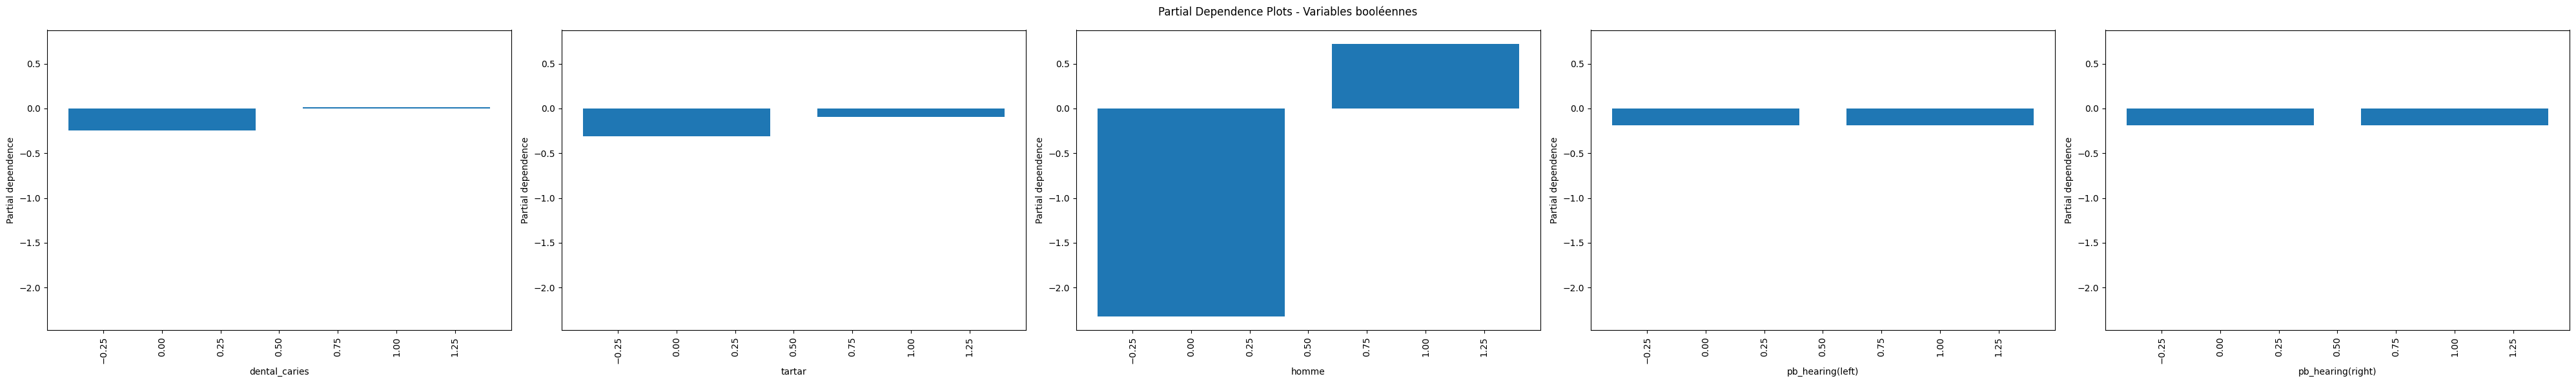

In [13]:


# Construction de la liste des index dans l’ordre du preprocessing
categorical_indices = [feature_names.index(var) for var in bool_cols]

# Création du PDP
fig, ax = plt.subplots(nrows=1, ncols=len(bool_cols), figsize=(8 * len(bool_cols), 6))

PartialDependenceDisplay.from_estimator(
    model,
    X_test_prepared,
    features=categorical_indices,
    categorical_features=categorical_indices,
    feature_names=feature_names,
    kind="average",
    ax=ax
)

plt.suptitle("Partial Dependence Plots - Variables booléennes")
plt.tight_layout()
plt.show()


Dans notre modèle, la variable homme est traitée comme une variable booléenne (0 = femme, 1 = homme).
Le graphique montre que, toutes choses égales par ailleurs, être un homme (valeur 1) augmente la probabilité prédite d’être fumeur,
tandis qu’être une femme (valeur 0) est associé à une contribution plus faible, voire négative

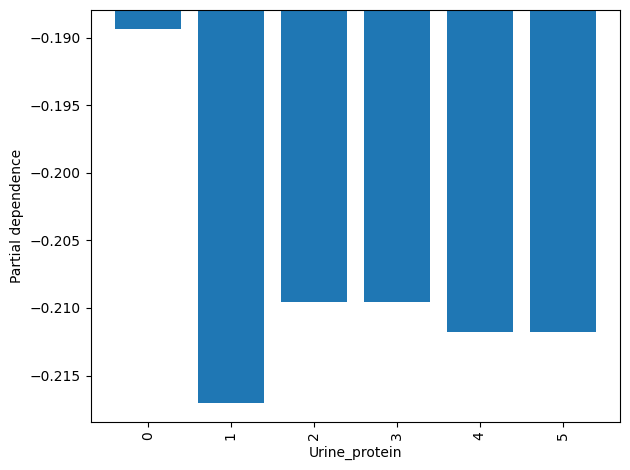

In [14]:
# Exemples pour PDP
categorical_indices = [feature_names.index(var) for var in ordinal_col]

PartialDependenceDisplay.from_estimator(
    model,
    X_test_prepared,
    features=categorical_indices,
    categorical_features=categorical_indices,
    feature_names=feature_names,
    kind="average"
)
plt.tight_layout()
plt.show()

###  3) ALE & Permutation feature Importance

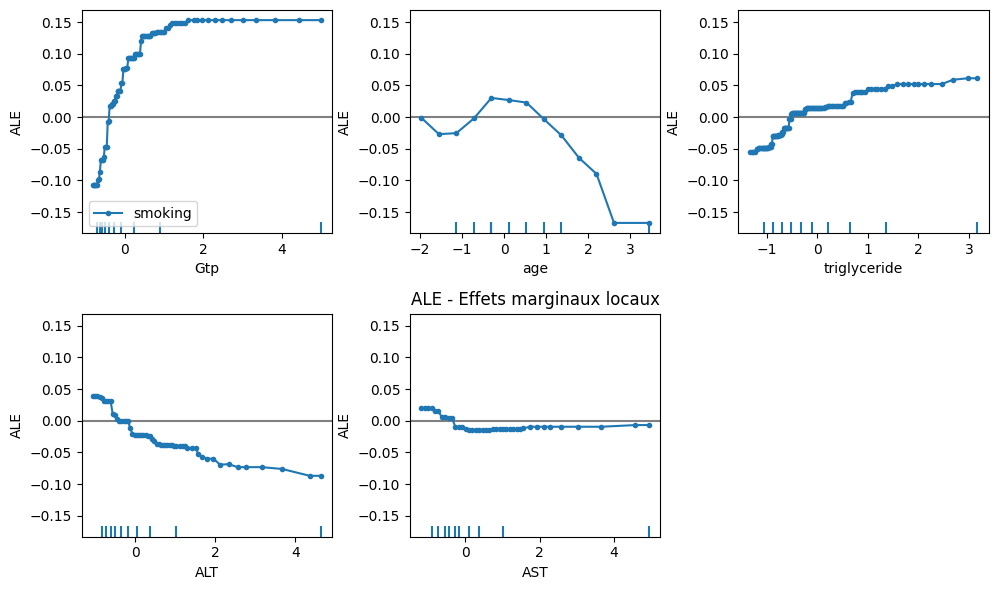

In [ ]:
# Initialisation de l'explainer ALE avec predict_proba[:, 1]
ale = ALE(
    lambda x: model.predict_proba(x)[:, 1],
    feature_names=feature_names,
    target_names=["smoking"]
)

# Explication (X_test_prepared doit être un tableau numpy)
exp = ale.explain(X_test_prepared)

# Visualisation pour 5 variables continues
_, ax = plt.subplots(figsize=(10, 6))
plot_ale(exp, features=features, ax=ax)
plt.title("ALE - Effets marginaux locaux")
plt.tight_layout()
plt.show()

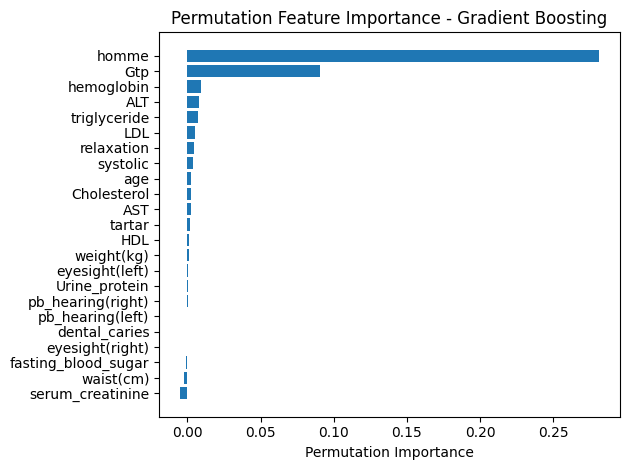

In [17]:

result = permutation_importance(
    model, X_test_prepared, y_test,
    scoring='recall', n_repeats=20, random_state=0, n_jobs=-1
)

perm_sorted_idx = result.importances_mean.argsort()
plt.barh(np.array(feature_names)[perm_sorted_idx], result.importances_mean[perm_sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance - Gradient Boosting")
plt.tight_layout()
plt.show()

## B. Interprétation locale

### 1) ICE (Individual conditional expectation)

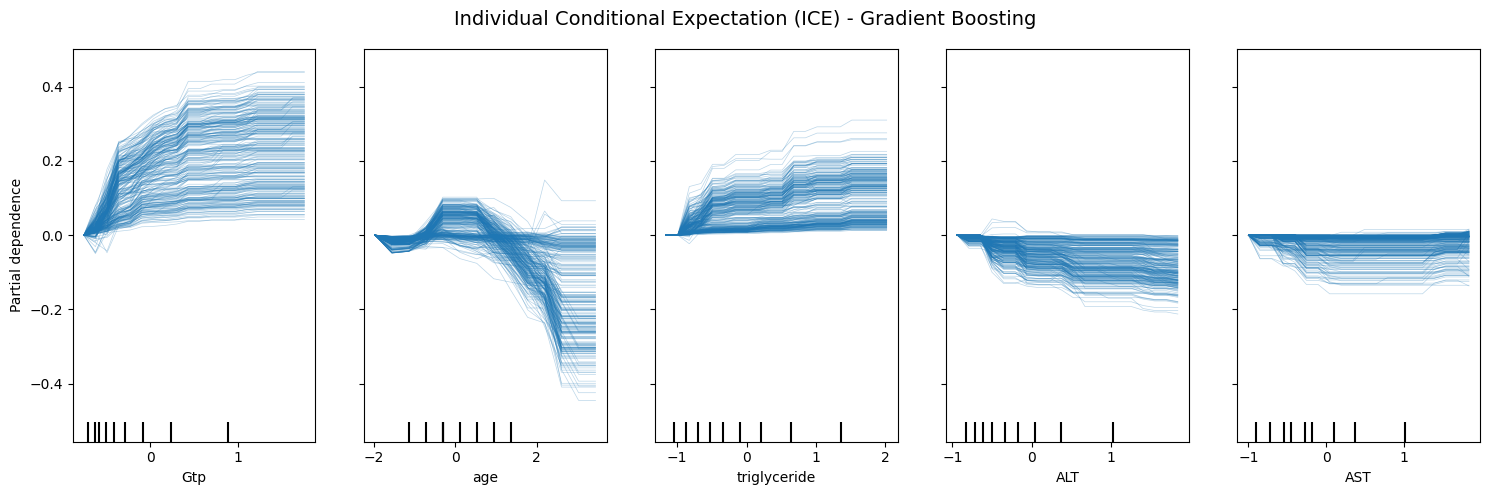

In [ ]:

# Vérifier que les noms sont bien dans feature_names
feature_indices = [feature_names.index(f) for f in features]

#  ICE
_, ax = plt.subplots(figsize=(15, 5))  
PartialDependenceDisplay.from_estimator(
    model,
    X_test_prepared,  # déjà standardisé
    features=feature_indices,
    feature_names=feature_names,
    kind="individual",         # <- clé pour ICE
    subsample=0.03,            # 5% des individus pour lisibilité
    grid_resolution=20,
    centered=True,             # centrer les courbes autour de la moyenne
    n_cols=6,
    ax=ax
)
plt.suptitle("Individual Conditional Expectation (ICE) - Gradient Boosting", fontsize=14)
plt.tight_layout()
plt.show()


### 2) LIME

In [26]:
# Explainer en mode classification
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_test_prepared,              # données transformées (centrées-réduites)
    feature_names=feature_names,                # noms des variables dans l'ordre du preprocessing
    class_names=["non-fumeur", "fumeur"],       # noms des classes
    mode='classification',
    verbose=True
)

# Index de l’individu à expliquer
i = 10

# Donnée transformée à expliquer
X_instance = X_test_prepared[i]

# Fonction de prédiction (probas)
predict_fn = model.predict_proba

# Explication LIME
exp = explainer.explain_instance(
    data_row=X_instance,
    predict_fn=predict_fn,
    num_features=5
)

# Affichage dans le notebook
exp.show_in_notebook()

Intercept 0.0677648774745605
Prediction_local [0.76923586]
Right: 0.7854746551348462


###  3) SHAP 

In [ ]:
explainer = shap.Explainer(model, feature_names=feature_names)
shap_values = explainer(X_test_prepared)

shap.initjs()

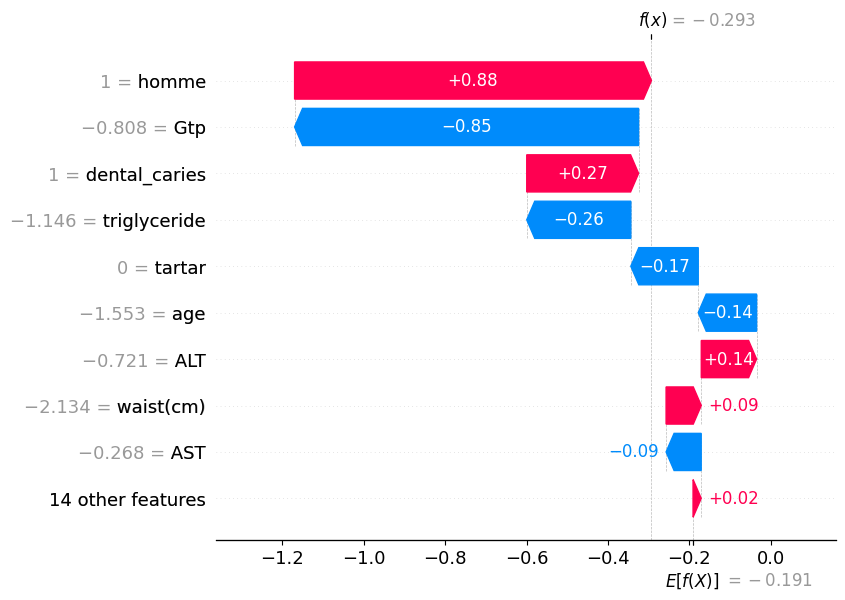

In [ ]:
# Afficher avec les noms des varaibles
shap.plots.waterfall(shap_values[0], max_display=10)

 autre représentation de ce graphique applatie  est le force_plot

In [46]:
shap.force_plot(shap_values[0])

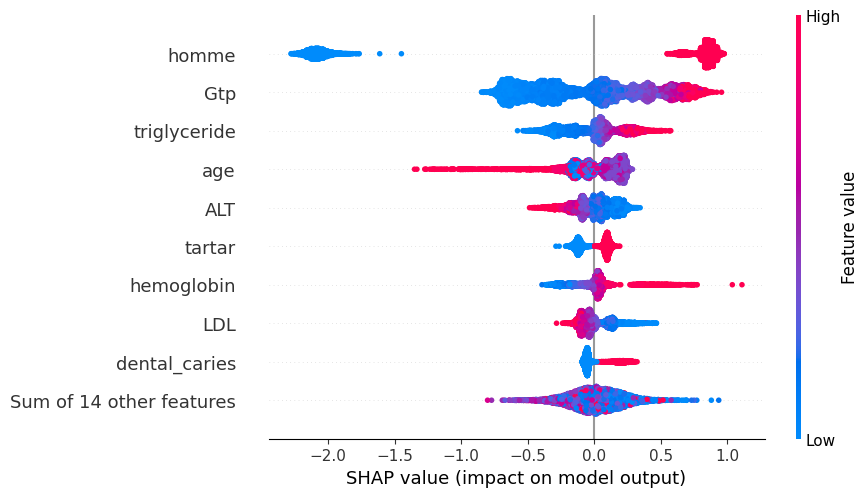

In [35]:
# Résumé global (importance + répartition)
shap.plots.beeswarm(shap_values)